In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [11]:

# Load dataset
df = pd.read_csv(r"C:\Users\dr274\Downloads\archive\weatherHistory.csv")

# Drop non-numeric or unnecessary columns
df_full = pd.read_csv(r"C:\Users\dr274\Downloads\archive\weatherHistory.csv")

df = df_full.select_dtypes(include=[np.number]).dropna()

# Features and target
X = df.drop(columns=['Wind Speed (km/h)']).values
y = df['Wind Speed (km/h)'].values.reshape(-1, 1)

C:\Users\dr274\AppData\Local\Temp\ipykernel_8020\285778227.py:3: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  plt.plot(pd.to_datetime(df_full['Formatted Date']), df_full['Wind Speed (km/h)'], label='Wind Speed')


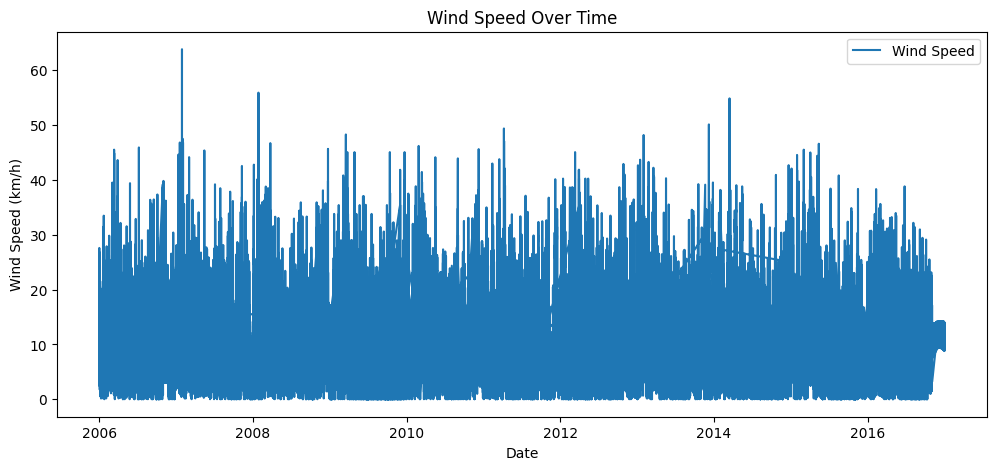

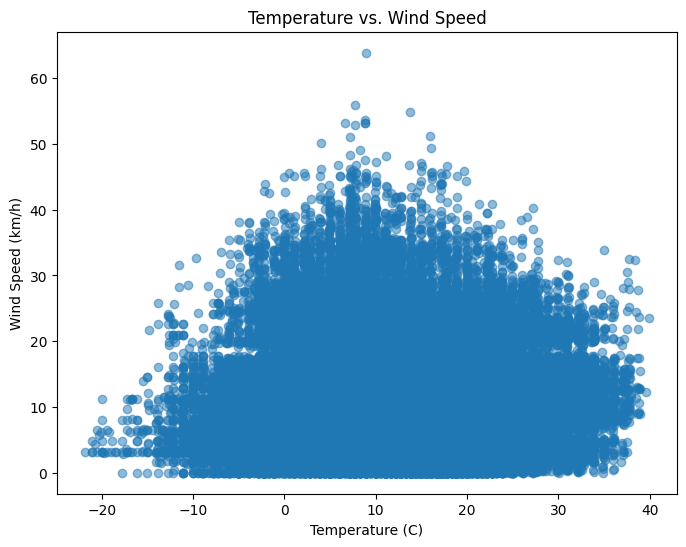

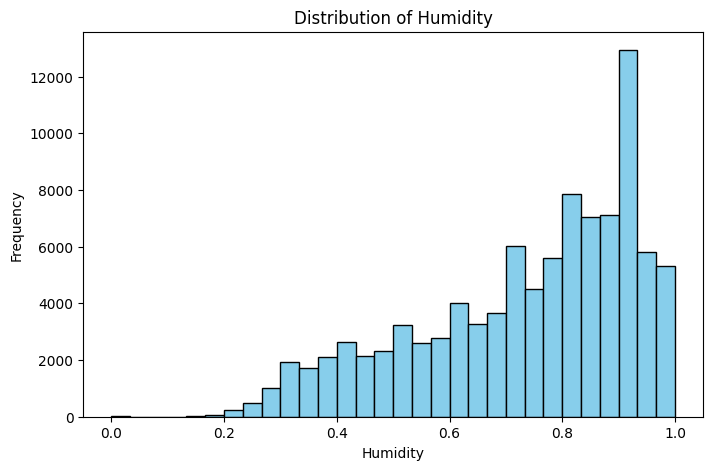

In [12]:

# Plot Wind Speed over time
plt.figure(figsize=(12, 5))
plt.plot(pd.to_datetime(df_full['Formatted Date']), df_full['Wind Speed (km/h)'], label='Wind Speed')
plt.xlabel('Date')
plt.ylabel('Wind Speed (km/h)')
plt.title('Wind Speed Over Time')
plt.legend()
plt.show()

# Scatter plot Temperature vs. Wind Speed
plt.figure(figsize=(8, 6))
plt.scatter(df_full['Temperature (C)'], df_full['Wind Speed (km/h)'], alpha=0.5)
plt.xlabel('Temperature (C)')
plt.ylabel('Wind Speed (km/h)')
plt.title('Temperature vs. Wind Speed')
plt.show()

# Histogram of Humidity
plt.figure(figsize=(8, 5))
plt.hist(df_full['Humidity'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Humidity')
plt.ylabel('Frequency')
plt.title('Distribution of Humidity')
plt.show()


In [13]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

# Sequence length (number of timesteps per sample)
seq_len = 5
X_seq, y_seq = [], []
for i in range(len(X) - seq_len):
    X_seq.append(X[i:i+seq_len])
    y_seq.append(y[i+seq_len])
X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# Convert to torch tensors
import torch
X_seq = torch.tensor(X_seq, dtype=torch.float32)
y_seq = torch.tensor(y_seq, dtype=torch.float32)

In [14]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # last timestep
        return out

In [15]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_list = []

for train_idx, val_idx in kf.split(X_seq):
    X_train, X_val = X_seq[train_idx], X_seq[val_idx]
    y_train, y_val = y_seq[train_idx], y_seq[val_idx]

    model = LSTMModel(input_size=X_seq.shape[2])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(20):  # increase for better performance
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val)
        val_loss = criterion(val_pred, y_val).item()
        mse_list.append(val_loss)

print(f"Average Validation MSE: {np.mean(mse_list):.4f}")

Average Validation MSE: 0.9347


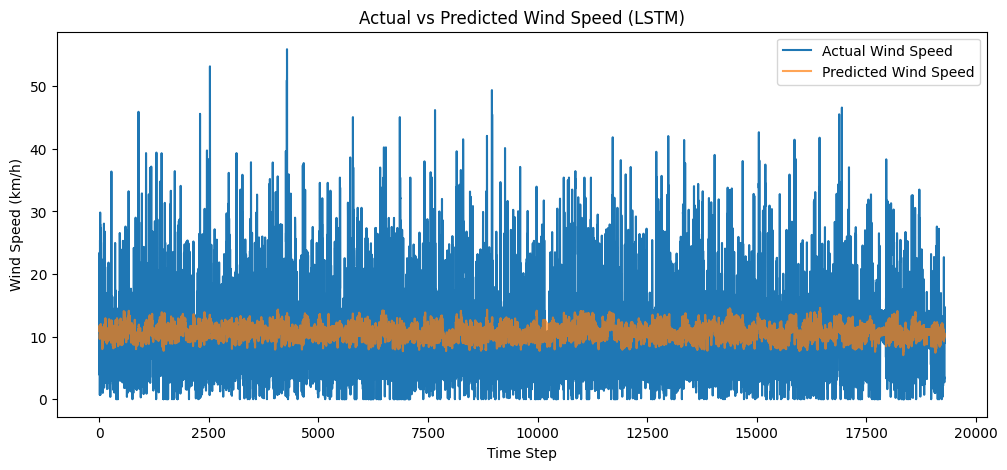

In [16]:
# Convert back to real units
y_val_real = scaler_y.inverse_transform(y_val.numpy())
val_pred_real = scaler_y.inverse_transform(val_pred.numpy())

plt.figure(figsize=(12, 5))
plt.plot(y_val_real, label='Actual Wind Speed')
plt.plot(val_pred_real, label='Predicted Wind Speed', alpha=0.7)
plt.xlabel('Time Step')
plt.ylabel('Wind Speed (km/h)')
plt.title('Actual vs Predicted Wind Speed (LSTM)')
plt.legend()
plt.show()
